In [2]:
import pandas as pd
from pycaret.time_series import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from pycaret.utils.time_series import clean_time_index


In [3]:
data = pd.read_csv('vl_lag_day.csv')

# แปลง timestamp และตั้งค่า index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

data = data.asfreq('D')

# เลือกเฉพาะฟีเจอร์ที่จำเป็น
features = ['pm_2_5', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3',
            'pm_2_5_lag_4', 'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7']
data = data[features]

# แบ่งข้อมูล Train/Test (80% Train / 20% Test)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ✅ ตรวจสอบว่าเป็น PeriodIndex หรือไม่
if not isinstance(train.index, pd.PeriodIndex):
    train.index = train.index.to_period('D')

if not isinstance(test.index, pd.PeriodIndex):
    test.index = test.index.to_period('D')

print(f'Train size: {train.shape}')
print(f'Test size: {test.shape}')


Train size: (790, 8)
Test size: (198, 8)


In [4]:
# STEP 3: ตั้งค่า PyCaret Environment
exp = setup(data=train, target='pm_2_5', session_id=123, fold=3,numeric_imputation_target='mean',
                numeric_imputation_exogenous='mean')

# ✅ สร้างโมเดล ARIMA
model = create_model('arima')

best_model = tune_model(model, search_algorithm='grid', n_iter=100, optimize='rmse')

print(best_model.get_params())

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(790, 8)"
5,Transformed data shape,"(790, 8)"
6,Transformed train set shape,"(789, 8)"
7,Transformed test set shape,"(1, 8)"
8,Rows with missing values,3.2%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-07-24,1.4316,1.0799,7.0031,7.0031,0.2315,0.2618
1,2024-07-25,1.0988,0.8284,5.3689,5.3689,0.2150,0.2408
2,2024-07-26,0.5561,0.4194,2.7217,2.7217,0.0958,0.0914
Mean,NaT,1.0288,0.7759,5.0312,5.0312,0.1807,0.1980
SD,NaT,0.3608,0.2722,1.7641,1.7641,0.0605,0.0759


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2024-07-24,2.6486,1.9980,12.9569,12.9569,0.4283,0.5450
1,2024-07-25,0.4273,0.3222,2.0879,2.0879,0.0836,0.0802
2,2024-07-26,0.9896,0.7464,4.8435,4.8435,0.1705,0.1863
Mean,NaT,1.3552,1.0222,6.6294,6.6294,0.2274,0.2705
SD,NaT,0.9430,0.7114,4.6134,4.6134,0.1464,0.1989


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   10.0s finished


{'concentrate_scale': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'mle_regression': True, 'order': (1, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 1, 0, 2), 'simple_differencing': False, 'start_params': None, 'suppress_warnings': False, 'time_varying_regression': False, 'trend': None, 'with_intercept': True}


In [5]:
rolling_forecast = []  
history = train.copy()

# ✅ พยากรณ์ล่วงหน้า 7 วัน
for day in range(7):
    # ✅ ดึงข้อมูลล่าสุดจาก History
    last_known = history.iloc[-1]

    future_exog = pd.DataFrame(
        {
            'pm_2_5_lag_1': [last_known['pm_2_5_lag_1']],
            'pm_2_5_lag_2': [last_known['pm_2_5_lag_2']],
            'pm_2_5_lag_3': [last_known['pm_2_5_lag_3']],
            'pm_2_5_lag_4': [last_known['pm_2_5_lag_4']],
            'pm_2_5_lag_5': [last_known['pm_2_5_lag_5']],
            'pm_2_5_lag_6': [last_known['pm_2_5_lag_6']],
            'pm_2_5_lag_7': [last_known['pm_2_5_lag_7']],
        },
        index=[history.index[-1] + 1]  # ✅ กำหนดวันถัดไป
    )

    # ✅ ใช้โมเดลที่ Fine-Tune แล้วในการพยากรณ์
    prediction = predict_model(best_model, fh=[1], X=future_exog)

    # ✅ เก็บค่าที่พยากรณ์ได้
    forecasted_value = prediction['y_pred'].iloc[0]
    rolling_forecast.append(forecasted_value)

    # ✅ อัปเดตค่า Lag ใน History สำหรับรอบถัดไป
    new_row = pd.DataFrame(
        {
            'pm_2_5': [forecasted_value],
            'pm_2_5_lag_1': [last_known['pm_2_5']],
            'pm_2_5_lag_2': [last_known['pm_2_5_lag_1']],
            'pm_2_5_lag_3': [last_known['pm_2_5_lag_2']],
            'pm_2_5_lag_4': [last_known['pm_2_5_lag_3']],
            'pm_2_5_lag_5': [last_known['pm_2_5_lag_4']],
            'pm_2_5_lag_6': [last_known['pm_2_5_lag_5']],
            'pm_2_5_lag_7': [last_known['pm_2_5_lag_6']],
        },
        index=[history.index[-1] + 1]
    )

    # ✅ ใช้ pd.concat() แทน append
    history = pd.concat([history, new_row])

print("\n✅ 7-Day Forecast Complete!")


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,1.9418,1.4643,9.4963,9.4963,0.3230,0.3852


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,5.2164,3.9336,25.5099,25.5099,0.8677,1.5326


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,3.7714,2.8440,18.4437,18.4437,0.6274,0.9141


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,4.3067,3.2476,21.0612,21.0612,0.7164,1.1162


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,1.8039,1.3603,8.8215,8.8215,0.3001,0.3530


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,2.4599,1.8550,12.0298,12.0298,0.4092,0.5144


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,0.3424,0.2582,1.6746,1.6746,0.0570,0.0586



✅ 7-Day Forecast Complete!


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ✅ ประเมินค่า MAE, RMSE, Accuracy ของ Forecast 7 วัน
actual = test['pm_2_5'].iloc[:7]  # ใช้ค่าจริงของ 7 วันแรกใน Test Set
mae = mean_absolute_error(actual, rolling_forecast)
mse = mean_squared_error(actual, rolling_forecast)
rmse = np.sqrt(mse)
accuracy = 100 - (mae / actual.mean()) * 100

print("\n🔎 7-Day Forecast Result:")
print(rolling_forecast)
print(f"\n✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ Accuracy: {accuracy:.2f}%")



🔎 7-Day Forecast Result:
[19.903, 3.8894, 10.9556, 8.3381, 20.5778, 17.3695, 27.7247]

✅ MAE: 7.89
✅ RMSE: 10.00
✅ Accuracy: 61.84%


In [7]:
# ✅ ข้อมูลล่าสุดสำหรับพยากรณ์
latest_data = pd.DataFrame(
    {
        'pm_2_5': [17.50299401],         # ค่า PM2.5 ล่าสุด
        'pm_2_5_lag_1': [12.76781778],
        'pm_2_5_lag_2': [9.606481481],
        'pm_2_5_lag_3': [7.547813195],
        'pm_2_5_lag_4': [9.977366255],
        'pm_2_5_lag_5': [9.531965272],
        'pm_2_5_lag_6': [5.881129272],
        'pm_2_5_lag_7': [4.481614996],
    },
    index=[pd.Period('2025-02-11', freq='D')]
)

# ✅ อัปเดตประวัติด้วยข้อมูลล่าสุด
history = pd.concat([history, latest_data])

# ✅ ทำการพยากรณ์ล่วงหน้า 7 วัน
future_forecast = []
for day in range(7):
    # ✅ ดึงข้อมูลล่าสุดจาก History
    last_known = history.iloc[-1]

    future_exog = pd.DataFrame(
        {
            'pm_2_5_lag_1': [last_known['pm_2_5_lag_1']],
            'pm_2_5_lag_2': [last_known['pm_2_5_lag_2']],
            'pm_2_5_lag_3': [last_known['pm_2_5_lag_3']],
            'pm_2_5_lag_4': [last_known['pm_2_5_lag_4']],
            'pm_2_5_lag_5': [last_known['pm_2_5_lag_5']],
            'pm_2_5_lag_6': [last_known['pm_2_5_lag_6']],
            'pm_2_5_lag_7': [last_known['pm_2_5_lag_7']],
        },
        index=[history.index[-1] + 1]  # ✅ กำหนดวันถัดไป
    )

    # ✅ ใช้โมเดลที่ Fine-Tune แล้วในการพยากรณ์
    prediction = predict_model(best_model, fh=[1], X=future_exog)

    # ✅ เก็บค่าที่พยากรณ์ได้
    forecasted_value = prediction['y_pred'].iloc[0]
    future_forecast.append(forecasted_value)

    # ✅ อัปเดตค่า Lag ใน History สำหรับรอบถัดไป
    new_row = pd.DataFrame(
        {
            'pm_2_5': [forecasted_value],
            'pm_2_5_lag_1': [last_known['pm_2_5']],
            'pm_2_5_lag_2': [last_known['pm_2_5_lag_1']],
            'pm_2_5_lag_3': [last_known['pm_2_5_lag_2']],
        },
        index=[history.index[-1] + 1]
    )

    # ✅ ใช้ pd.concat() แทน append
    history = pd.concat([history, new_row])

# ✅ แสดงผลลัพธ์การพยากรณ์
print("\n✅ 7-Day Forecast from Lastest Data:")
print(future_forecast)



,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,1.0518,0.7932,5.1439,5.1439,0.1750,0.1917


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,1.8595,1.4022,9.0936,9.0936,0.3093,0.3659


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,2.2042,1.6621,10.7793,10.7793,0.3667,0.4490


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,3.0937,2.3329,15.1292,15.1292,0.5146,0.6929


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,2.4792,1.8695,12.1240,12.1240,0.4124,0.5195


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,2.4773,1.8681,12.1151,12.1151,0.4121,0.5190


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,ARIMA,1.8602,1.4027,9.0969,9.0969,0.3094,0.3661



✅ 7-Day Forecast from Lastest Data:
[24.2554, 20.3057, 18.62, 14.2701, 17.2753, 17.2842, 20.3024]


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ ใช้ค่าจริงของ 7 วันแรกใน Test Set เทียบกับค่าที่พยากรณ์ได้
actual = test['pm_2_5'].iloc[:7]

# ✅ คำนวณ Metric ต่าง ๆ
mae = mean_absolute_error(actual, future_forecast)
mse = mean_squared_error(actual, future_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual - future_forecast) / actual)) * 100
accuracy = 100 - mape

# ✅ แสดงผลลัพธ์
print("\n🔎 Forecast Evaluation:")
print(f"✅ MAE: {mae:.2f}")               # ค่า MAE ยิ่งต่ำยิ่งดี
print(f"✅ MSE: {mse:.2f}")               # ค่า MSE ยิ่งต่ำยิ่งดี
print(f"✅ RMSE: {rmse:.2f}")             # ค่า RMSE ยิ่งต่ำยิ่งดี
print(f"✅ MAPE: {mape:.2f}%")            # ค่า MAPE ยิ่งต่ำยิ่งดี
print(f"✅ Accuracy: {accuracy:.2f}%")     # ค่า Accuracy ยิ่งสูงยิ่งดี



🔎 Forecast Evaluation:
✅ MAE: 5.91
✅ MSE: 52.15
✅ RMSE: 7.22
✅ MAPE: 29.29%
✅ Accuracy: 70.71%


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ✅ ค่าจริง (Actual Values)
actual_values = test['pm_2_5'].iloc[:7]  # ใช้ข้อมูล test set สำหรับการวัดความแม่นยำ

# ✅ ค่าที่พยากรณ์ได้ (Predicted Values)
predicted_values = future_forecast  # ใช้ค่าที่พยากรณ์ได้จากโมเดล ARIMA

# ✅ ตรวจสอบว่าจำนวนข้อมูลจริงและค่าที่พยากรณ์ได้เท่ากัน
if len(actual_values) != len(predicted_values):
    raise ValueError(f"Length mismatch: actual_values has {len(actual_values)} values, but predicted_values has {len(predicted_values)} values.")

# ✅ คำนวณเมตริกความแม่นยำ
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100  # MAPE (%)

# ✅ แสดงผลลัพธ์
print("\n✅ ARIMA Model Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


✅ ARIMA Model Accuracy Metrics:
Mean Absolute Error (MAE): 5.9066
Mean Squared Error (MSE): 52.1462
Root Mean Squared Error (RMSE): 7.2212
Mean Absolute Percentage Error (MAPE): 29.2949%


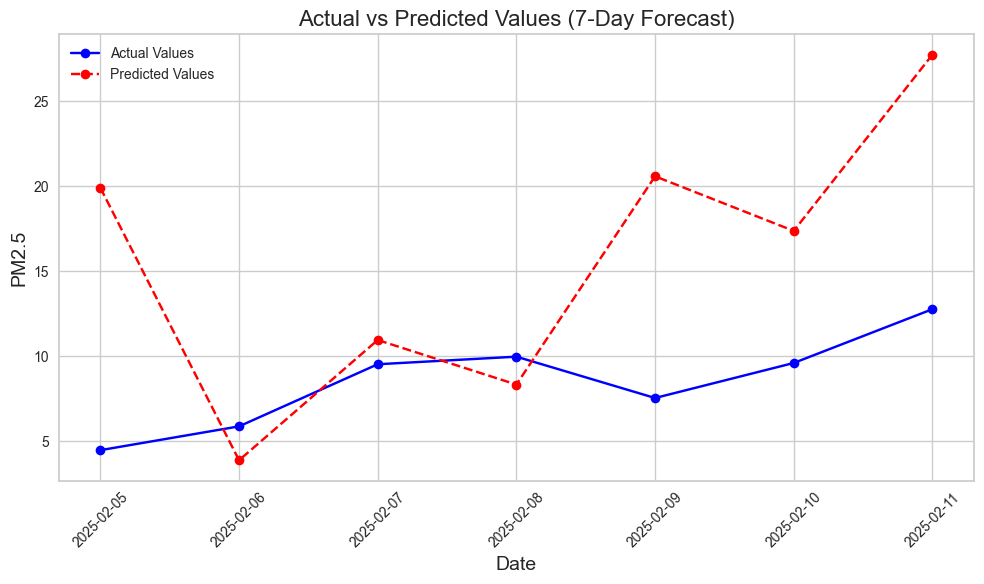

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# ข้อมูลจริง (actual_values) และค่าที่พยากรณ์ได้ (rolling_forecast)
actual_values = test['pm_2_5'].values[-7:]  # ใช้ 7 วันสุดท้ายของชุดทดสอบ
predicted_values = rolling_forecast  # ค่าที่พยากรณ์ได้

# วันที่สำหรับแกน X (ใช้ index ของ test)
dates = test.index[-7:].to_timestamp()  # แปลง PeriodIndex เป็น DatetimeIndex

# สร้างกราฟ
plt.figure(figsize=(10, 6))  # กำหนดขนาดกราฟ
plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', color='blue')  # พล็อตค่าจริง
plt.plot(dates, predicted_values, label='Predicted Values', marker='o', linestyle='--', color='red')  # พล็อตค่าที่พยากรณ์

# เพิ่มข้อมูลบนกราฟ
plt.title('Actual vs Predicted Values (7-Day Forecast)', fontsize=16)  # ชื่อกราฟ
plt.xlabel('Date', fontsize=14)  # แกน X
plt.ylabel('PM2.5', fontsize=14)  # แกน Y
plt.xticks(dates, [date.strftime('%Y-%m-%d') for date in dates], rotation=45)  # กำหนดรูปแบบวันที่และหมุนแกน X
plt.legend()  # แสดง legend
plt.grid(True)  # เพิ่ม grid
plt.tight_layout()  # ปรับ layout
plt.show()  # แสดงกราฟ

In [11]:
# ✅ Finalize Model
final_model = finalize_model(best_model)

print("✅ Model finalized successfully!")

✅ Model finalized successfully!


In [12]:
save_model(final_model, 'arima_model_4')

print(f"✅ Final model saved as {'arima_model_4'}.pkl")

Transformation Pipeline and Model Successfully Saved
✅ Final model saved as arima_model_4.pkl
